In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv('/content/sample_data/07_train.csv')

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# split target and features
X_train = train_set.drop('Premium Amount', axis=1)
y_train = train_set['Premium Amount'].copy()
X_test = test_set.drop('Premium Amount', axis=1)
y_test = test_set['Premium Amount'].copy()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

## Momentum

In [18]:
# cyclic momentum
class CyclicMomentumScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, start_lr=1e-4, max_lr=1e-3, start_mom=0.9, final_mom=0.7, cyclic_mom=False, cyclic_lr=False):
        self.iterations = iterations
        self.start_lr = start_lr
        self.max_lr = max_lr
        self.start_mom = start_mom
        self.final_mom = final_mom
        self.iteration = 0
        self.lr = []
        self.cyclic_mom = cyclic_mom
        self.cyclic_lr = cyclic_lr
        self.current_lr = start_lr

    def _interpolate(self, iter1, iter2, lr1, lr2):
        slope = (lr2 - lr1) / (iter2 - iter1)
        delta = self.iteration - iter1
        return delta * slope + lr1

    def on_batch_begin(self, batch, logs=None):
        # learning rate
        if self.cyclic_lr:
            lr = self._interpolate(0, self.iterations, self.start_lr, self.max_lr)
            self.current_lr = lr
            lr = float(lr)
            self.model.optimizer.learning_rate.assign(lr)

        # momentum
        if self.cyclic_mom:
            mom = self._interpolate(0, self.iterations, self.start_mom, self.final_mom)
            mom = float(mom)
            self.model.optimizer.momentum = mom
        self.iteration += 1

    # add learning rate to history
    def on_epoch_begin(self, epoch, logs):
        print(self.current_lr)
        print(self.model.optimizer.momentum)
        self.lr.append(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)))

### Decreasing Momentum
- model 1: 0.9
- model 2: 0.8-1
- model 3: 0.95-0.8
- model 4: 0.97-0.7

Cyclical Learning Rate: 0.002-0.02

WD: 1e-6

In [22]:
# model 1: 0.9
import math
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, weight_decay=1e-6, momentum=0.9),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=False, cyclic_lr=True,
                         start_lr=0.002, max_lr=0.006)]

history5 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


0.002
0.9
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 1.3272 - val_loss: 1.0972
0.002199973333333333
0.9
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0942 - val_loss: 1.0914
0.0023999733333333333
0.9
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 1.0889 - val_loss: 1.1385
0.0025999733333333334
0.9
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1.0900 - val_loss: 2.1540
0.0027999733333333335
0.9
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.0866 - val_loss: 1.6373
0.0029999733333333336
0.9
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0867 - val_loss: 1.1174
0.003199973333333333
0.9
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0859 - val_loss: 1.1076
0.0033999733333333333
0.9
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0852 - val_loss: 1.3888
0.0035999733333333334
0.9
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.0861 - 

In [10]:
# model 2: 0.8-1
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, weight_decay=1e-6, momentum=0.8),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=True, cyclic_lr=True,
                         start_lr=0.002, max_lr=0.006,
                         start_mom=0.8, final_mom=1.0)]

history6 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.002
0.8
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1.4505 - val_loss: 1.0984
0.002199973333333333
0.8099986666666668
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0953 - val_loss: 1.0990
0.0023999733333333333
0.8199986666666667
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0928 - val_loss: 1.1013
0.0025999733333333334
0.8299986666666667
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0879 - val_loss: 1.1013
0.0027999733333333335
0.8399986666666667
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0863 - val_loss: 1.6673
0.0029999733333333336
0.8499986666666667
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0836 - val_loss: 1.1029
0.003199973333333333
0.8599986666666667
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0850 - val_loss: 1.0949
0.0033999733333333333
0.8699986666666667
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.0858 - val_loss: 

In [19]:
# model 3: 0.95-0.8
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, weight_decay=1e-6, momentum=0.95),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=True, cyclic_lr=True,
                         start_lr=0.002, max_lr=0.006,
                         start_mom=0.95, final_mom=0.8)]

history7 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.002
0.95
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1.2828 - val_loss: 1.2122
0.002199973333333333
0.9425009999999999
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0947 - val_loss: 1.1256
0.0023999733333333333
0.935001
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0909 - val_loss: 1.1102
0.0025999733333333334
0.927501
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0914 - val_loss: 1.8960
0.0027999733333333335
0.920001
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0895 - val_loss: 2.0935
0.0029999733333333336
0.912501
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0890 - val_loss: 1.1004
0.003199973333333333
0.9050009999999999
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0883 - val_loss: 1.1136
0.0033999733333333333
0.897501
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.0866 - val_loss: 1.1181
0.0035999733333333334
0.890001
Epoch 9/20


In [20]:
# model 4: 0.97-0.7
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, weight_decay=1e-6, momentum=0.97),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=True, cyclic_lr=True,
                         start_lr=0.002, max_lr=0.006,
                         start_mom=0.97, final_mom=0.7)]

history8 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.002
0.97
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1.2917 - val_loss: 1.1018
0.002199973333333333
0.9565018
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 1.0937 - val_loss: 1.1035
0.0023999733333333333
0.9430018
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0917 - val_loss: 1.1083
0.0025999733333333334
0.9295017999999999
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0889 - val_loss: 2.6876
0.0027999733333333335
0.9160018
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0880 - val_loss: 2.6362
0.0029999733333333336
0.9025018
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 1.0839 - val_loss: 1.1660
0.003199973333333333
0.8890018
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.0824 - val_loss: 1.2994
0.0033999733333333333
0.8755018
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0815 - val_loss: 1.0971
0.0035999733333333334
0.8620017999999999
Epoch

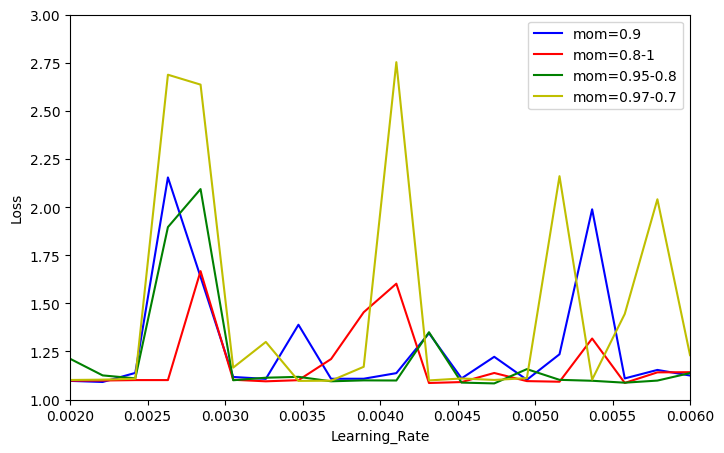

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
l_rates = np.linspace(0.002, 0.006, 20)

plt.plot(l_rates, history5.history['val_loss'], 'b-', label='mom=0.9')
plt.plot(l_rates, history6.history['val_loss'], 'r-', label='mom=0.8-1')
plt.plot(l_rates, history7.history['val_loss'], 'g-', label='mom=0.95-0.8')
plt.plot(l_rates, history8.history['val_loss'], 'y-', label='mom=0.97-0.7')

plt.xlabel('Learning_Rate')
plt.ylabel('Loss')
plt.xlim([0.002, 0.006])
plt.ylim([1, 3])
plt.legend()
plt.show()